# Chapter 15

In [ ]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)

In [3]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## Testing the N400 effect using cross-validation

In [6]:
data("df_eeg")

In [9]:
df_eeg <- df_eeg %>%
  mutate(c_cloze = cloze - mean(cloze))

In [10]:
prior_sih_full <-
  c(
    prior(normal(0, 10), class = Intercept),
    prior(normal(0, 10), class = b, coef = c_cloze),
    prior(normal(0, 50), class = sigma),
    prior(normal(0, 20),class = sd, coef = Intercept,group = subj),
    prior(normal(0, 20),class = sd, coef = c_cloze,group = subj),
    prior(lkj(2), class = cor, group = subj),
    prior(normal(0, 20),class = sd, coef = Intercept, group = item),
    prior(normal(0, 20),class = sd, coef = c_cloze, group = item),
    prior(lkj(2), class = cor, group = item))

In [ ]:
fit_N400_sih <- brm(n400 ~ c_cloze + (c_cloze | subj) +
  (c_cloze | item),
prior = prior_sih_full,
data = df_eeg
)

In [12]:
fit_N400_sih

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: n400 ~ c_cloze + (c_cloze | subj) + (c_cloze | item) 
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 80) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              1.52      0.35     0.80     2.20 1.00     1625
sd(c_cloze)                2.30      1.02     0.30     4.22 1.01      779
cor(Intercept,c_cloze)    -0.42      0.31    -0.90     0.32 1.00     1710
                       Tail_ESS
sd(Intercept)              2042
sd(c_cloze)                 848
cor(Intercept,c_cloze)     2078

~subj (Number of levels: 37) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              2.20      0.36     1.55     2.99 1.00     1563
sd(c_cloze)                1.41      0.88     0.06     3.23 1.00 

In [ ]:
# null model
fit_N400_sih_null <- update(fit_N400_sih, ~ . - c_cloze) 

### Cross-validation with PSIS-LOO

In [14]:
# approximation of psis-loo CV for model
(loo_sih <- loo(fit_N400_sih))


Computed from 4000 by 2863 log-likelihood matrix

         Estimate   SE
elpd_loo -11092.5 46.7
p_loo        81.2  2.8
looic     22185.0 93.4
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [15]:
# approximation of psis-loo CV for null model
(loo_sih_null <- loo(fit_N400_sih_null))



Computed from 4000 by 2863 log-likelihood matrix

         Estimate   SE
elpd_loo -11095.1 46.5
p_loo        90.1  3.0
looic     22190.2 93.0
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [16]:
# comparison
loo_compare(loo_sih, loo_sih_null)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_N400_sih,0.00000,0.000000,-11092.52,46.72481,81.15082,2.774399,22185.05,93.44962
fit_N400_sih_null,-2.56065,2.564078,-11095.08,46.52219,90.06797,3.004672,22190.17,93.04437


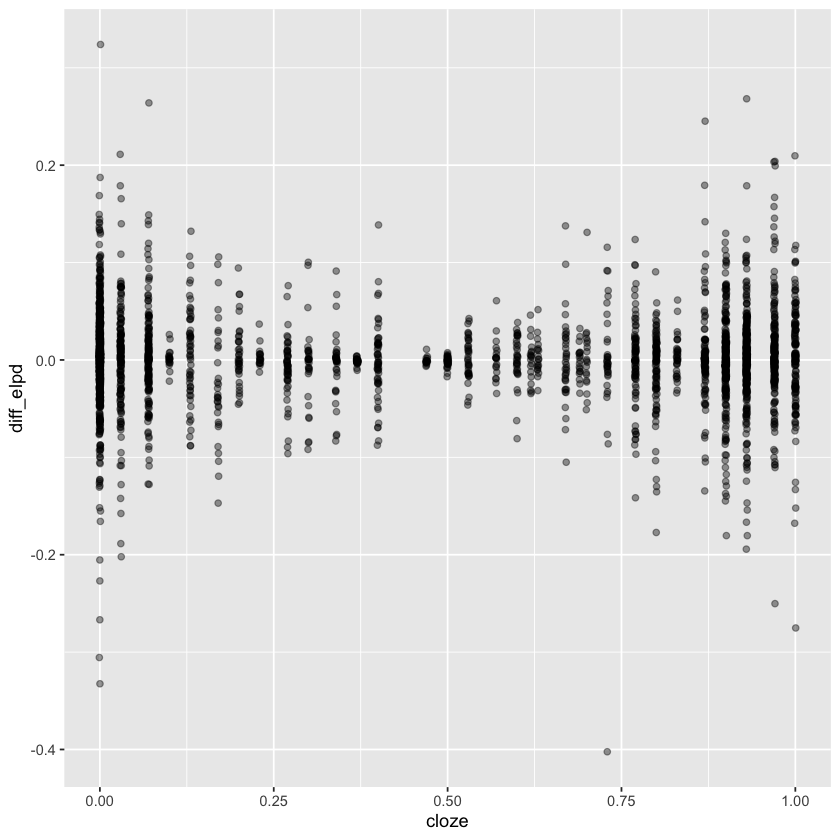

In [17]:
df_eeg <- mutate(df_eeg,
  diff_elpd = loo_sih$pointwise[, "elpd_loo"] -
    loo_sih_null$pointwise[, "elpd_loo"]
)
ggplot(df_eeg, aes(x = cloze, y = diff_elpd)) +
  geom_point(alpha = .4, position = position_jitter(w = .001, h = 0))

### Cross-validation with K-fold

In [18]:
kfold_sih <- kfold(fit_N400_sih,
                    folds = "stratified",
                    group = "subj")

Fitting model 1 out of 10

Fitting model 2 out of 10

Fitting model 3 out of 10

Fitting model 4 out of 10

Fitting model 5 out of 10

Fitting model 6 out of 10

Fitting model 7 out of 10

Fitting model 8 out of 10

Fitting model 9 out of 10

Fitting model 10 out of 10

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling



In [19]:
kfold_sih_null <- kfold(fit_N400_sih_null,
                         folds = "stratified",
                         group = "subj")

Fitting model 1 out of 10

Fitting model 2 out of 10

Fitting model 3 out of 10

Fitting model 4 out of 10

Fitting model 5 out of 10

Fitting model 6 out of 10

Fitting model 7 out of 10

Fitting model 8 out of 10

Fitting model 9 out of 10

Fitting model 10 out of 10

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling

Start sampling



In [20]:
kfold_sih


Based on 10-fold cross-validation

           Estimate   SE
elpd_kfold -11098.1 46.9
p_kfold        86.7  3.8
kfoldic     22196.2 93.9

In [21]:
kfold_sih_null


Based on 10-fold cross-validation

           Estimate   SE
elpd_kfold -11097.8 46.4
p_kfold        92.8  3.7
kfoldic     22195.6 92.9

In [22]:
loo_compare(kfold_sih, kfold_sih_null)

,elpd_diff,se_diff,elpd_kfold,se_elpd_kfold,p_kfold,se_p_kfold
fit_N400_sih_null,0.0000000,0.000000,-11097.82,46.42693,92.80878,3.705845
fit_N400_sih,-0.2665293,4.327809,-11098.09,46.93883,86.71881,3.753913


## Comparing different likelihoods with cross-validation

In [ ]:
data("df_stroop")
df_stroop <- df_stroop %>%
  mutate(c_cond = if_else(condition == "Incongruent", 1, -1))

[1] 0.44741104 0.43735265 0.30176196 0.50235454 0.91364130 0.04918532

In [ ]:
fit_stroop <- brm(RT ~ c_cond + (c_cond | subj),
  family = lognormal(),
  prior =
    c(
      prior(normal(6, 1.5), class = Intercept),
      prior(normal(0, 1), class = b),
      prior(normal(0, 1), class = sigma),
      prior(normal(0, 1), class = sd),
      prior(lkj(2), class = cor)
    ),
  data = df_stroop
)

[1] 0.6100235 0.6076280 0.5748732 0.6230125 0.7137447 0.5122939

In [ ]:
loo_stroop_log <- loo(fit_stroop)
loo_stroop_log

[1] 50  5

In [ ]:
fit_stroop_normal <- brm(RT ~ c_cond + (c_cond | subj),
  family = gaussian(),
  prior =
    c(
      prior(normal(400, 600), class = Intercept),
      prior(normal(0, 100), class = b),
      prior(normal(0, 300), class = sigma),
      prior(normal(0, 300), class = sd),
      prior(lkj(2), class = cor)
    ),
  data = df_stroop
)

0.25,0.2632341,0.02924824,0.04575176,0.4117659
0.25,0.2648511,0.02942790,0.04557210,0.4101489
0.25,0.2869606,0.03188451,0.04311549,0.3880394


In [ ]:
loo_stroop_normal <- loo(fit_stroop_normal)
loo_stroop_normal

 In this particular case, this approximation won’t solve our problem. We skip that step here. We can use exact LOO (rather than its approximation) for the problematic observations. By setting reloo = TRUE, we re-fit the 3 problematic observations with k values over 0.7 using exact LOO-CV.

In [ ]:
loo_stroop_normal <- loo(fit_stroop_normal, reloo = TRUE)
loo_stroop_normal

In [ ]:
loo_compare(loo_stroop_log, loo_stroop_normal)

In [ ]:
df_stroop <- mutate(df_stroop,
  diff_elpd = loo_stroop_log$pointwise[, "elpd_loo"] -
    loo_stroop_normal$pointwise[, "elpd_loo"]
)
ggplot(df_stroop, aes(x = RT, y = diff_elpd)) +
  geom_point(alpha = .4)

## Cross-validation in Stan

### PSIS-LOO-CV in Stan

Example with pupil size:

In [23]:
data("df_pupil")

In [24]:
# center variables
df_pupil <- df_pupil %>%
  mutate(
    c_trial = trial - mean(trial),
    c_load = load - mean(load)
  )

In [25]:
# data for Stan model
ls_pupil <- list(
  c_load = df_pupil$c_load,
  c_trial= df_pupil$c_trial,
  p_size = df_pupil$p_size,
  N = nrow(df_pupil)
)

In [ ]:
# fit real model 
fit_pupil_int_pos_ll <- stan(
  file = "stan_models_16/pupil_CV_loo.stan",
  iter = 3000,
  data = ls_pupil
)

In [ ]:
# fit null model
fit_pupil_int_null_ll <- stan(
  file = "stan_models_16/pupil_CV_null.stan",
  iter = 3000,
  data = ls_pupil
)

In [28]:
(loo_pos <- loo(fit_pupil_int_pos_ll))

Warning message:
"Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
"



Computed from 6000 by 41 log-likelihood matrix

         Estimate   SE
elpd_loo   -251.1  5.3
p_loo         5.2  1.5
looic       502.1 10.6
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     38    92.7%   2666      
 (0.5, 0.7]   (ok)        3     7.3%   299       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

In [29]:
(loo_null <- loo(fit_pupil_int_null_ll))


Computed from 6000 by 41 log-likelihood matrix

         Estimate  SE
elpd_loo   -255.4 4.6
p_loo         4.3 1.1
looic       510.8 9.2
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [30]:
loo_compare(loo_pos, loo_null)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model1,0.000000,0.000000,-251.0559,5.320055,5.248764,1.502638,502.1118,10.640109
model2,-4.322237,3.485691,-255.3782,4.612538,4.345843,1.127257,510.7563,9.225075


## Excercises

## 16.1 

### Predictive accuracy of the linear and the logarithm effect of cloze probability

Is there a difference in predictive accuracy between the model that incorporates a linear effect of cloze probability and one that incorporates log-transformed cloze probabilities?

In [53]:
data("df_eeg")

df_eeg <- df_eeg %>%
  mutate(c_cloze = cloze - mean(cloze))

In [65]:
head(df_eeg)

subj,cloze,item,n400,cloze_ans,N,c_cloze,scloze,c_logscloze
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,1,7.08,0,44,-0.4760915,0.02173913,-2.304063
1,0.03,2,-0.68,1,44,-0.4460915,0.04347826,-1.610916
1,1.00,3,1.39,44,44,0.5239085,0.97826087,1.502600
1,0.93,4,22.78,41,44,0.4539085,0.91304348,1.433607
1,0.00,5,1.61,0,44,-0.4760915,0.02173913,-2.304063
1,0.00,6,3.01,0,44,-0.4760915,0.02173913,-2.304063


In [58]:
df_eeg <- df_eeg %>%
  mutate(
    scloze = (cloze_ans + 1) / (N + 2),
    c_logscloze = log(scloze) - mean(log(scloze))
  )

In [56]:
ls_eeg <- list(
  N = nrow(df_eeg),
  c_cloze = df_eeg$c_cloze,
  signal = df_eeg$n400
)

In [ ]:
# fit normal model 
fit_n400_normal <- stan(
  file = "stan_models_16/cloze_normal_cv.stan",
  iter = 3000,
  data = ls_eeg
)

In [68]:
print(fit_n400_normal, pairs=c("alpha", "beta", "sigma")

Inference for Stan model: anon_model.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                   mean se_mean   sd      2.5%       25%       50%       75%
alpha              3.66    0.00 0.22      3.22      3.51      3.67      3.82
beta               2.27    0.01 0.54      1.18      1.90      2.26      2.63
sigma             11.82    0.00 0.16     11.51     11.72     11.82     11.93
log_lik[1]        -3.46    0.00 0.02     -3.49     -3.47     -3.46     -3.45
log_lik[2]        -3.43    0.00 0.01     -3.46     -3.44     -3.43     -3.42
log_lik[3]        -3.43    0.00 0.01     -3.46     -3.44     -3.43     -3.42
log_lik[4]        -4.56    0.00 0.05     -4.65     -4.59     -4.56     -4.53
log_lik[5]        -3.39    0.00 0.01     -3.42     -3.40     -3.39     -3.38
log_lik[6]        -3.39    0.00 0.01     -3.41     -3.40     -3.39     -3.38
log_lik[7]        -3.50    0.00 0.02     -3.53     -3.51     -3.50     -3.

In [63]:
ls_eeg_log <- list(
  N = nrow(df_eeg),
  c_cloze = df_eeg$c_logscloze,
  signal = df_eeg$n400
)

In [ ]:
# fit normal model 
fit_n400_log <- stan(
  file = "stan_models_16/cloze_normal_cv.stan",
  iter = 3000,
  data = ls_eeg_log
)

In [67]:
print(fit_n400_log, pairs=c("alpha", "beta", "sigma")

Inference for Stan model: anon_model.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                   mean se_mean   sd      2.5%       25%       50%       75%
alpha              3.67    0.00 0.22      3.23      3.52      3.67      3.82
beta               0.68    0.00 0.15      0.39      0.58      0.68      0.78
sigma             11.81    0.00 0.15     11.50     11.70     11.81     11.91
log_lik[1]        -3.48    0.00 0.02     -3.51     -3.49     -3.48     -3.47
log_lik[2]        -3.43    0.00 0.01     -3.45     -3.44     -3.43     -3.42
log_lik[3]        -3.43    0.00 0.01     -3.45     -3.44     -3.43     -3.42
log_lik[4]        -4.57    0.00 0.04     -4.65     -4.60     -4.57     -4.54
log_lik[5]        -3.39    0.00 0.01     -3.41     -3.40     -3.39     -3.38
log_lik[6]        -3.39    0.00 0.01     -3.42     -3.40     -3.39     -3.38
log_lik[7]        -3.49    0.00 0.02     -3.52     -3.50     -3.49     -3.

In [69]:
loo_normal <- loo(fit_n400_normal)
loo_normal


Computed from 6000 by 2863 log-likelihood matrix

         Estimate   SE
elpd_loo -11134.3 46.2
p_loo         3.5  0.3
looic     22268.5 92.5
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [70]:
loo_log <- loo(fit_n400_log)
loo_log


Computed from 6000 by 2863 log-likelihood matrix

         Estimate   SE
elpd_loo -11131.4 46.4
p_loo         3.5  0.3
looic     22262.7 92.7
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [12]:
loo_compare(loo_normal, loo_log)

ERROR: Error in loo_compare(loo_normal, loo_log): nie znaleziono obiektu 'loo_normal'


## 16.2 

### Lognormal model in Stan

Use PSIS-LOO to compare a model of Stroop as the one in 11.1 with a model that assumes no population-level effect

In [ ]:
data("df_stroop")
(df_stroop <- df_stroop %>%
  mutate(c_cond = if_else(condition == "Incongruent", 1, -1)))

In [5]:
# define data for Stan model

ls_stroop <- list(
  N = nrow(df_stroop),
  rt = df_stroop$RT,
  c_cond = df_stroop$c_cond,
  subj = df_stroop$subj,
  N_subj = max(df_stroop$subj)
)

In [ ]:
fit_stroop_corr_uc <- stan("stan_models_16/stroop_h_cv.stan", data = ls_stroop)

In [14]:
print(fit_stroop_corr_uc, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha    6.33       0 0.02 6.29 6.32 6.33 6.34  6.37   486 1.01
beta     0.04       0 0.01 0.03 0.03 0.04 0.04  0.05  3493 1.00
tau_u[1] 0.12       0 0.01 0.09 0.11 0.11 0.12  0.15   763 1.00
tau_u[2] 0.02       0 0.01 0.00 0.01 0.02 0.03  0.04  1106 1.01
sigma    0.28       0 0.00 0.27 0.28 0.28 0.28  0.29  5773 1.00

Samples were drawn using NUTS(diag_e) at Thu Sep 15 14:29:15 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [16]:
# define data for Stan model

ls_stroop_simple <- list(
  N = nrow(df_stroop),
  rt = df_stroop$RT,
  c_cond = df_stroop$c_cond
)

In [18]:
fit_stroop_simple <- stan("stan_models_16/stroop_simple_cv.stan", data = ls_stroop_simple)

In [19]:
print(fit_stroop_simple, pars = c("alpha", "beta", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha 6.33       0 0.01 6.32 6.32 6.33 6.33  6.34  3339    1
beta  0.04       0 0.01 0.03 0.03 0.04 0.04  0.05  3737    1
sigma 0.30       0 0.00 0.30 0.30 0.30 0.30  0.31  2869    1

Samples were drawn using NUTS(diag_e) at Thu Sep 15 14:36:11 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Comparison

In [20]:
loo_stroop_h <- loo(fit_stroop_corr_uc)
loo_stroop_h

Warning message:
"Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
"



Computed from 4000 by 3058 log-likelihood matrix

            Estimate       SE
elpd_loo -64527723.5 338049.8
p_loo      6116223.6 114570.2
looic    129055446.9 676099.7
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)        0    0.0%  <NA>      
 (0.5, 0.7]   (ok)          0    0.0%  <NA>      
   (0.7, 1]   (bad)         0    0.0%  <NA>      
   (1, Inf)   (very bad) 3031  100.0%  0         
See help('pareto-k-diagnostic') for details.

In [23]:
loo_stroop_simple <- loo(fit_stroop_simple)
loo_stroop_simple

Warning message:
"Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
"



Computed from 4000 by 3058 log-likelihood matrix

            Estimate       SE
elpd_loo -62155605.6 292777.0
p_loo      1299814.2  37522.1
looic    124311211.1 585553.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)        0    0.0%  <NA>      
 (0.5, 0.7]   (ok)          0    0.0%  <NA>      
   (0.7, 1]   (bad)         0    0.0%  <NA>      
   (1, Inf)   (very bad) 3057  100.0%  0         
See help('pareto-k-diagnostic') for details.

In [24]:
loo_compare(loo_stroop_h, loo_stroop_simple)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model2,0,0.00,-62155606,292777.0,1299814,37522.14,124311211,585553.9
model1,-2372118,97699.51,-64527723,338049.8,6116224,114570.16,129055447,676099.7
